In [7]:
"""
File: 
Author: Chenlong Zhao
Date: 2024-08-28
Description: cooperate with mini_dataset, predict on pt file with trained model, and display the result
"""
import matplotlib.pyplot as plt
import numpy as np
import torch
import numpy as np
from typing import  List
from models.hivt import HiVT

def plot_single_vehicle(
    sample_past_trajectory: np.ndarray,  # (20, 2)
    sample_groundtruth: np.ndarray,  # (20, 2) 
    sample_forecasted_trajectories: List[np.ndarray],  # List[(30, 2)]
    ):

    ## Plot history
    plt.plot(
        sample_past_trajectory[:, 0],
        sample_past_trajectory[:, 1],
        color="#ECA154",
        label="Past Trajectory",
        alpha=1,
        linewidth=2.2,
        zorder=15,
        ls = '-'
    )

    ## Plot future
    plt.plot(
        sample_groundtruth[:, 0],
        sample_groundtruth[:, 1],
        color="#d33e4c",
        label="Ground Truth",
        alpha=1,
        linewidth=2.2,
        zorder=20,
        ls = "--"
    )

    ## Plot prediction
    for j in range(len(sample_forecasted_trajectories)):
        plt.plot(
            sample_forecasted_trajectories[j][:, 0],
            sample_forecasted_trajectories[j][:, 1],
            color="#007672",
            label="Forecasted Trajectory",
            alpha=1,
            linewidth=2.0,
            zorder=15,
            ls = "--"
        )
        
        # Plot the end marker for forcasted trajectories
        plt.arrow(
            sample_forecasted_trajectories[j][-2, 0], 
            sample_forecasted_trajectories[j][-2, 1],
            sample_forecasted_trajectories[j][-1, 0] - sample_forecasted_trajectories[j][-2, 0],
            sample_forecasted_trajectories[j][-1, 1] - sample_forecasted_trajectories[j][-2, 1],
            color="#007672",
            label="Forecasted Trajectory",
            alpha=1,
            linewidth=2.5,
            zorder=15,
            head_width=1.1,
        )
    
    # Plot the end marker for history
    plt.arrow(
            sample_past_trajectory[-2, 0], 
            sample_past_trajectory[-2, 1],
            sample_past_trajectory[-1, 0] - sample_past_trajectory[-2, 0],
            sample_past_trajectory[-1, 1] - sample_past_trajectory[-2, 1],
            color="#ECA154",
            label="Past Trajectory",
            alpha=1,
            linewidth=2.5,
            zorder=25,
            head_width=1.0,
        )

    ## Plot the end marker for future
    plt.arrow(
            sample_groundtruth[-2, 0], 
            sample_groundtruth[-2, 1],
            sample_groundtruth[-1, 0] - sample_groundtruth[-2, 0],
            sample_groundtruth[-1, 1] - sample_groundtruth[-2, 1],
            color="#d33e4c",
            label="Ground Truth",
            alpha=1,
            linewidth=2.5,
            zorder=25,
            head_width=1.0,
        )

In [8]:
# model_unit = HiVT.load_from_checkpoint('/home/alon/Learning/HiVT/checkpoints/HiVT-64/checkpoints/epoch=63-step=411903.ckpt', parallel=True)
model_unit = HiVT.load_from_checkpoint('/home/alon/Learning/HiVT/lightning_logs/version_57/checkpoints/epoch=34-step=269849.ckpt', parallel=True)

info_ = model_unit.eval()

送入模型的.pt数据格式与内容 cat


/home/alon/Learning/HiVT/models/local_encoder.py:420: UserWarning: operator() profile_node %28 : int[] = prim::profile_ivalue(%size.4)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  alpha = softmax(alpha, index, ptr, size_i)


y_hat.size =  torch.Size([8, 6, 50, 2])


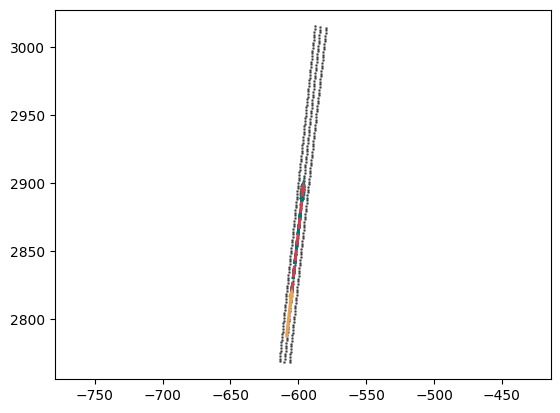

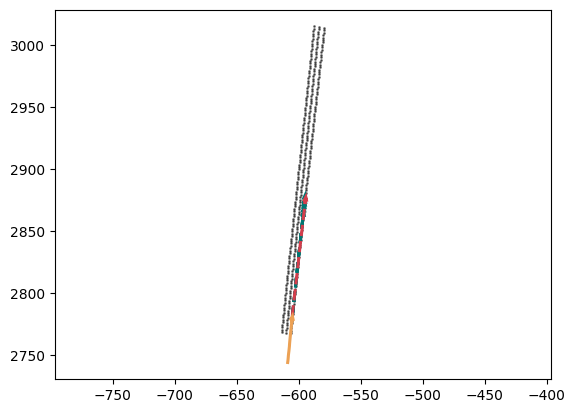

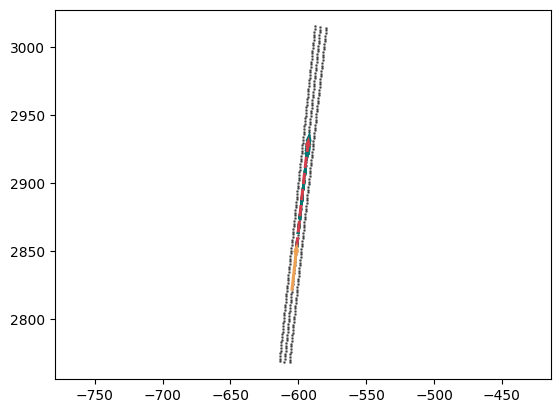

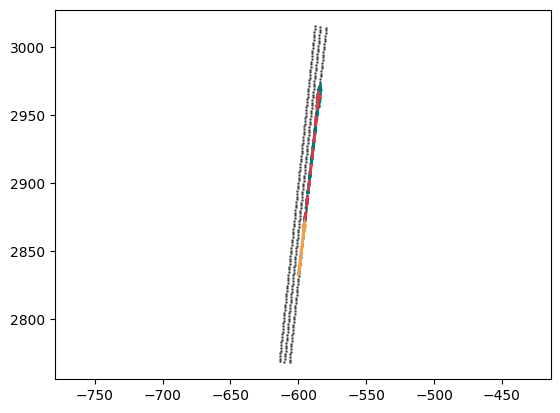

In [9]:

# test_data = torch.load('/home/alon/Learning/HiVT/mini_data/44.pt')
# test_data = torch.load('/home/alon/Learning/HiVT/pre-process/data_collection_CHERY_E0Y_10034_EVENT_MANUAL_2024-08-21-10-56-27_19.pt')
test_data = torch.load('/home/alon/Learning/HiVT/data_root/val/processed/data_collection_CHERY_E0Y_10034_EVENT_MANUAL_2024-08-23-15-00-34_no_camera_39.pt')

# print('padding_mask =',test_data['padding_mask'])
# print('av_index =',test_data['av_index'])
with torch.no_grad(): 
    y_hat_agent, pi_agent, seq_id ,position_sce= model_unit.predition_unit_batch(test_data,batch_idx=0)
y_hat_agent = y_hat_agent.permute(0, 1, 2, 3)
print('y_hat.size = ',y_hat_agent.size())
pred_traj_np = y_hat_agent.cpu().numpy()
full_traj = position_sce
if full_traj.is_cuda:
    full_traj = full_traj.cpu()

full_traj_np = full_traj.numpy()
raw_lane_pos = test_data['raw_lane_pos']
raw_lane_pos_np = raw_lane_pos.cpu().numpy()
index_agent = test_data['agent_index']
av_agent = test_data['av_index']
complete_idx = test_data['complete_samples']

for i in  complete_idx:
    actor_to_show = i
    sample_past_trajectory = full_traj[actor_to_show,:20,:]
    sample_groundtruth = full_traj[actor_to_show,20:,:]
    full_truth = full_traj_np[actor_to_show]
    sample_forecasted_trajectories = [pred_traj_np[actor_to_show][i] for i in range(pred_traj_np.shape[1])]
    # orange red green: past future prediction
    plot_single_vehicle(sample_past_trajectory,sample_groundtruth,sample_forecasted_trajectories)
    plt.scatter(
    raw_lane_pos_np[:, 0],
    raw_lane_pos_np[:, 1],
    color="#000000",
    label="Lane",
    alpha=0.5,
    s = 1,
    zorder=10)
    plt.axis('equal')
    plt.show()
    plt.close()